# Convert to IC50 value

In [36]:
import pandas as pd
import numpy as np

df = pd.read_csv('ADCY8_activity_data.csv') 

def convert_ic50_to_pic50(ic50):
    ic50_M = ic50 * 10**-9  
    return -np.log10(ic50_M)

df['pIC50'] = df['IC50 (nM)'].apply(convert_ic50_to_pic50)

df = df.drop(['IC50 (nM)'], axis=1)

df.to_csv('ADCY8_activity_pic50.csv', index=False)


# framework
각 SMILES 문자열에 대해 fingerprints를 계산하고 데이터 프레임에 새 열로 추가한 다음 데이터를 기능(X)과 대상(y)으로 나누고 마지막으로 데이터를 훈련 및 테스트 세트로 너눔.

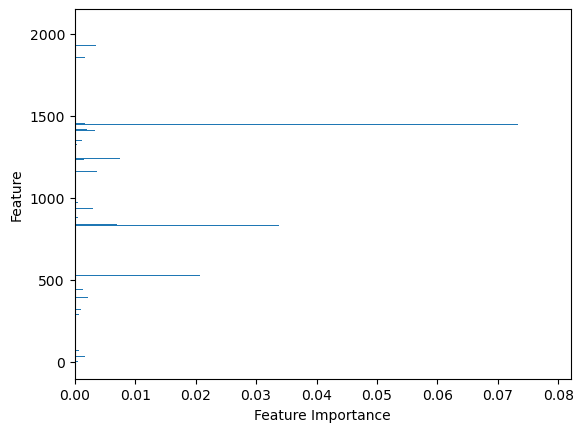


Performance on TRAIN data:
Mean Squared Error: 0.046752458673966685
R2 Score: 0.8480268715015438
Mean Absolute Error: 0.16595999057997513
Root Mean Squared Error: 0.21622316867987734


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('ADCY8_activity_pic50.csv')

# Define the nBits variable outside the function
nBits = 2048

def compute_fingerprint(smiles, radius=2, nBits=nBits):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    return pd.Series(list(fingerprint))

# Apply the function to the 'SMILES' column
df_fingerprints = df['SMILES'].apply(compute_fingerprint)
df = pd.concat([df, df_fingerprints], axis=1)
X = df.iloc[:, -nBits:]  
y = df['pIC50']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Get feature importance
importances = model.feature_importances_
plt.barh(X.columns, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

selected_features = X.columns[importances > np.mean(importances)]

# Re-train the model using only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model.fit(X_train_selected, y_train)
predictions_train = model.predict(X_train_selected)
mse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print("\nPerformance on TRAIN data:")
print(f'Mean Squared Error: {mse_train}')
print(f'R2 Score: {r2_train}')
print(f'Mean Absolute Error: {mean_absolute_error(y_train, predictions_train)}')
print(f'Root Mean Squared Error: {np.sqrt(mse_train)}')


In [5]:
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

# Load data
df = pd.read_csv('ADCY8_activity_pic50.csv')

def compute_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    return pd.Series(list(fingerprint))

df_fingerprints = df['SMILES'].apply(compute_fingerprint)
df = pd.concat([df, df_fingerprints], axis=1)

X = df.iloc[:, -2048:]  # Assuming nBits=2048 for the fingerprint
y = df['pIC50']

model = RandomForestRegressor(random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cross_val_results = cross_val_score(model, X, y, cv=kf, scoring='r2')
predictions = cross_val_predict(model, X, y, cv=kf)

mse = mean_squared_error(y, predictions)
mae = mean_absolute_error(y, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y, predictions)

print(f'R2 Score: {np.max(cross_val_results)} (+/- {cross_val_results.std()})')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')


R2 Score: 0.3193490657235687 (+/- 0.1016643510644242)
Mean Squared Error: 0.26417035642154174
Mean Absolute Error: 0.4109364911528876
Root Mean Squared Error: 0.5139750542794288


# Prediction vs Observation Chart

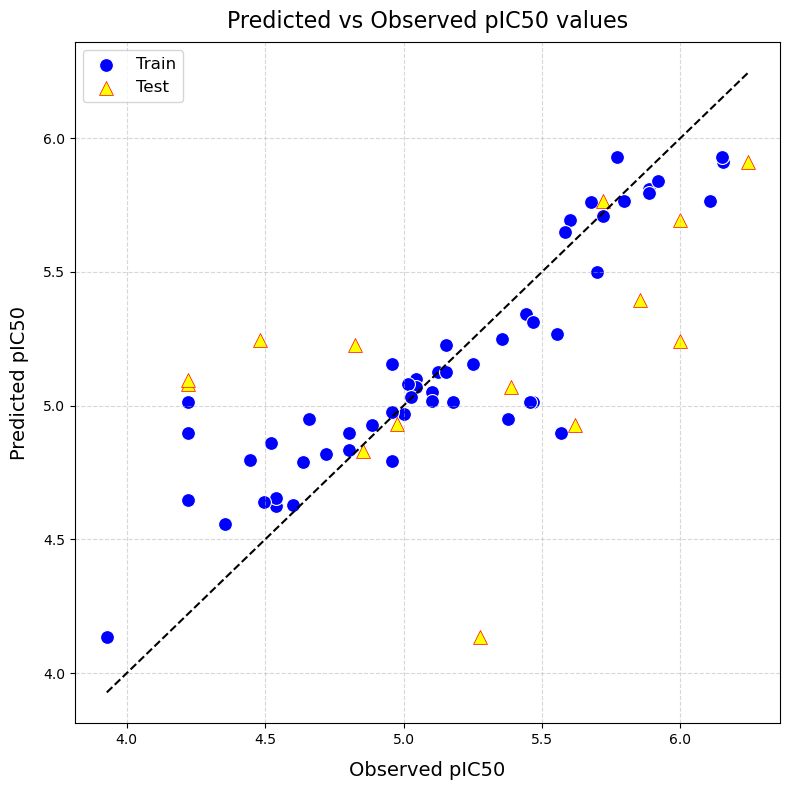

In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define the function to compute Morgan fingerprints
def compute_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    return pd.Series(list(fingerprint))

# Load your dataset
df = pd.read_csv('ADCY8_activity_pic50.csv')  # Assuming you have a CSV named 'ADCY8_activity_pic50.csv'

# Compute fingerprints and update the DataFrame
df_fingerprints = df['SMILES'].apply(compute_fingerprint)
df = pd.concat([df, df_fingerprints], axis=1)

# Update feature matrix 'X' and target 'y'
X = df.iloc[:, -2048:]  # Assuming nBits=2048 for the fingerprint
y = df['pIC50']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_train, y=predictions_train, marker='o', color='blue', alpha=1, label='Train', s=100)
sns.scatterplot(x=y_test, y=predictions_test, marker='^', color='yellow', edgecolor='red', linewidth=0.5, alpha=1, label='Test', s=100)

plt.plot([y.min(), y.max()], [y.min(), y.max()], color='black', linestyle='--')
plt.xlabel("Observed pIC50", fontsize=14, labelpad=10)
plt.ylabel("Predicted pIC50", fontsize=14, labelpad=10)
plt.title("Predicted vs Observed pIC50 values", fontsize=16, pad=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.savefig('my_plot.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


# residual plot：Residual=Observed−Predicted
이상적으로는 잔차가 무작위로 분포되어야 하며 뚜렷한 패턴을 보여주지않음. 잔차그림에서 패턴이나 추세가 관찰되는 경우 이는 모델이 일부 설명 변수와 반응 변수 간의 관계를 포착하지 못하고 있음을 나타낼 수 있음.

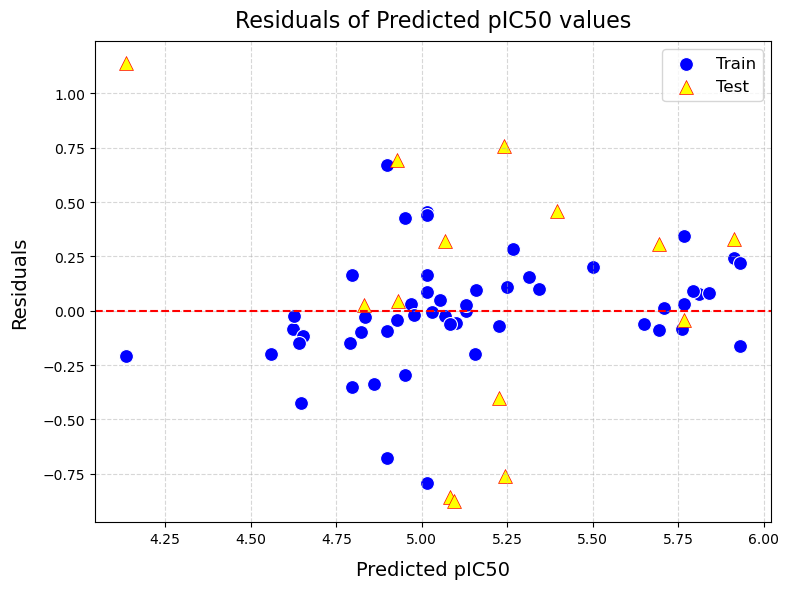

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute residuals
residuals_test = y_test - predictions_test
residuals_train = y_train - predictions_train

# Plotting
plt.figure(figsize=(8, 6))

# Train data in blue
sns.scatterplot(x=predictions_train, y=residuals_train, marker='o', color='blue', alpha=1, label='Train', s=100)

# Test data in green
sns.scatterplot(x=predictions_test, y=residuals_test, marker='^', color='yellow',edgecolor='red', linewidth=0.5, alpha=1, label='Test', s=100)

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--')

# Labeling the axes and title of the plot
plt.xlabel("Predicted pIC50", fontsize=14, labelpad=10)
plt.ylabel("Residuals", fontsize=14, labelpad=10)
plt.title("Residuals of Predicted pIC50 values", fontsize=16, pad=10)

# Adding legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('my_plot.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
